In [1]:
from utils.analysis.analyzer import *
import re
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/soumyajit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# file_paths = ["../../US_climate_change_policy.pdf", "../../National_sustainabilyt_mission.pdf", "../../UKEF_Climate_Change_Strategy_2021.pdf"]
file_paths = ["../../National_sustainabilyt_mission.pdf"]

documents = []
for file_path in file_paths:
    text = read_pdf(file_path, return_list=False)
    documents.append(text)

#### Model Building

In [4]:
sentences = sent_tokenize("\n\n".join(documents))


In [154]:
docs = sentences.copy()

import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')

# Split the documents into tokens, remove links and non-alphanumeric characters
import re
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

for idx in range(len(docs)):
    # Remove links
    docs[idx] = re.sub(r'http\S+|www.\S+', '', docs[idx])
    
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    
    # Remove non-alphanumeric characters and tokenize
    docs[idx] = tokenizer.tokenize(re.sub(r'\W', ' ', docs[idx]))

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

# Remove stopwords
docs = [[token for token in doc if token not in stopwords.words('english')] for doc in docs]

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/soumyajit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [155]:
lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [156]:
dictionary = Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]


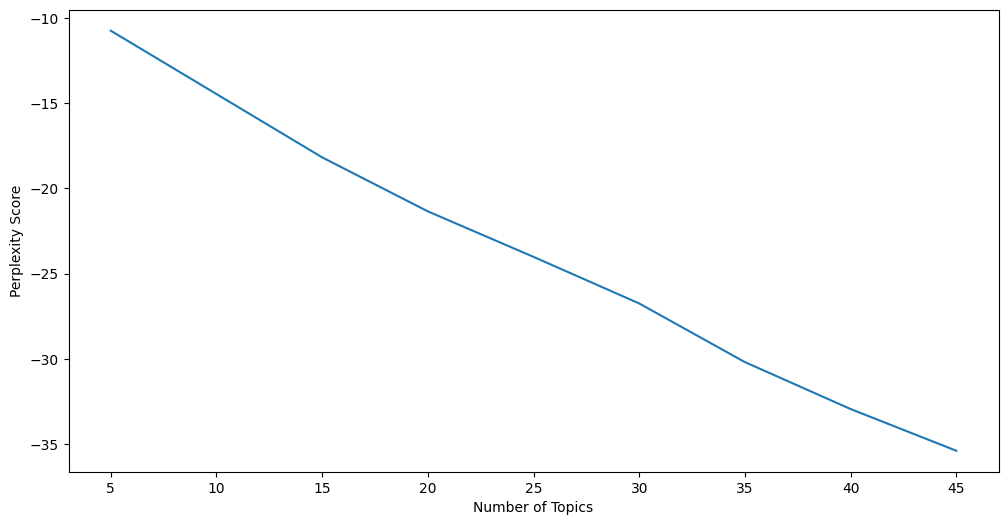

In [157]:
train_corpus = corpus[:int(len(corpus)*0.8)]
valid_corpus = corpus[int(len(corpus)*0.8):]

perplexity_values = []
num_topics_list = range(5, 50, 5)

for num_topics in num_topics_list:
    model = LdaModel(corpus=train_corpus, id2word=dictionary, num_topics=num_topics)
    perplexity_values.append(model.log_perplexity(valid_corpus))

plt.figure(figsize=(12, 6))
plt.plot(num_topics_list, perplexity_values)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity Score")
plt.show()

In [158]:
model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=20)

In [159]:
def print_topics(topics):
    topics_ls = []
    for topic in topics:
        words = topic[1].split("+")
        topic_words = [word.split("*")[1].replace('"', '').strip() for word in words]
        topics_ls.append(topic_words)
    for i, topic in enumerate(topics_ls):
        print(f"Topic_{i+1}:", ' '.join(topic))

topics = model.print_topics(num_words=30)
print_topics(topics)
# topics
# for topic in topics:
#     print(f"Topic_{topic[0]}: {topic[1]}\n")


Topic_1: plan principle national mission water climate change co2 another around changing annual well timber carbon non small storage service sequestration provisioning product ntfps community meant cabinet wildlife centrally india15 affair
Topic_2: change climate forest gw energy mission national sustainable efficiency knowledge strategic aim solar additional currently installation process tendering early power upscaled capacity adaptation policy ha technology creating innovative regime strengthen
Topic_3: forest ha ecosystem adaptation mission million carbon increased improved service climate sequestration cover year measure aim livelihood document sink specie responding around based result tonne annual mitigation biodiversity household vulnerable
Topic_4: mission national energy water efficiency himalayan climate change capacity area knowledge resource framework policy ecosystem agriculture use conservation ensure enhanced nmeee sustaining four impact biodiversity glacier protection

In [160]:
len(topics)

20

In [161]:
df = pd.DataFrame()
for i, topic in enumerate(topics):
    words = topic[1].split("+")
    topic_words = [word.split("*")[1].replace('"', '').strip() for word in words]
    topic_weights = [float(word.split("*")[0]) for word in words]
    df[f"Topic_{i}"] = topic_words
    df[f"Topic_{i}_weights"] = topic_weights

In [163]:
# df = df[[f"Topic_{i}" for i in range(len(topics))] + [f"Topic_{i}_weights" for i in range(len(topics))]]
new_ordering = []
for i in range(len(topics)):
    new_ordering.append(f"Topic_{i}")
    new_ordering.append(f"Topic_{i}_weights")

df = df[new_ordering]

In [164]:
df.to_csv("topics_IN.csv", index=False)

#### Inference

In [165]:
# For each doc in documents split the text into sentences and find topic distribution for each sentence
tokenizer = RegexpTokenizer(r'\w+')

# Split the documents into sentences
sentences = [sent_tokenize(doc) for doc in documents]
doc_sentences = [[None] * len(sentences[idx]) for idx in range(len(sentences))]

for idx in range(len(sentences)):
    for ind in range(len(sentences[idx])):
        # Remove links -> convert to lowercase -> remove non-alphanumeric characters -> tokenize
        sentence = re.sub(r'http\S+|www.\S+', '', sentences[idx][ind])
        sentence = tokenizer.tokenize(re.sub(r'\W', ' ', sentence.lower()))
        # Remove numbers, but not words that contain numbers.
        sentence = [token for token in sentence if not token.isnumeric()]
        # Remove words that are only one character.
        sentence = [token for token in sentence if len(token) > 1]
        # Remove stopwords
        sentence = [token for token in sentence if token not in stopwords.words('english')]

        # Store in doc_sentences
        doc_sentences[idx][ind] = sentence

# Remove empty sentences & Create a version of sentences where the sentences corresponding to the empty sentences are removed
# Initialize new lists
filtered_doc_sentences = []
filtered_sentences = []

# Iterate over each document
for doc_idx, doc in enumerate(doc_sentences):
    temp_doc = []
    temp_sent = []
    for sent_idx, sentence in enumerate(doc):
        # If the sentence is not empty, add it to the temporary lists
        if sentence:
            temp_doc.append(sentence)
            temp_sent.append(sentences[doc_idx][sent_idx])
    # Add the temporary lists to the new lists
    filtered_doc_sentences.append(temp_doc)
    filtered_sentences.append(temp_sent)

In [166]:
# Lemmatize the tokens
lemmatizer = WordNetLemmatizer()
filtered_doc_sentences = [[[lemmatizer.lemmatize(token) for token in ls] for ls in doc] for doc in filtered_doc_sentences]

In [167]:
sentence_bow = [[dictionary.doc2bow(sentence) for sentence in doc] for doc in filtered_doc_sentences]
topic_distribution = [[model.get_document_topics(sentence) for sentence in doc] for doc in sentence_bow]

In [168]:
import pandas as pd
df = pd.DataFrame()

doc_country_map = {0: 'US', 2: 'UK', 1: 'IN'}

num_topics = 20
for i in range(len(topic_distribution)):
    for dist, sentence in zip(topic_distribution[i], filtered_sentences[i]):
        dist_dict = dict(dist)
        dist_dict['Sentence'] = sentence
        dist_dict['Doc_ID'] = doc_country_map[i]
        df_ = pd.DataFrame([dist_dict])
        df = pd.concat([df, df_], ignore_index=True)

df.rename(columns={i: f'Topic_{i}' for i in range(num_topics)}, inplace=True)
df = df[['Doc_ID', 'Sentence'] + [f'Topic_{i}' for i in range(num_topics)]]


In [169]:
# Compute mean and standard deviation for each topic (for each topic, across all documents)

# Compute mean for each topic
topic_means = df[[f'Topic_{i}' for i in range(num_topics)]].mean()

# Compute standard deviation for each topic
topic_stds = df[[f'Topic_{i}' for i in range(num_topics)]].std()

print("Topic Means: \n", topic_means)
print("Topic Standard Deviations: \n", topic_stds)

Topic Means: 
 Topic_0     0.063077
Topic_1     0.184206
Topic_2     0.081522
Topic_3     0.477881
Topic_4     0.240923
Topic_5     0.255322
Topic_6     0.318985
Topic_7     0.080641
Topic_8     0.197431
Topic_9     0.195711
Topic_10    0.108505
Topic_11    0.223061
Topic_12    0.011795
Topic_13    0.137206
Topic_14    0.132793
Topic_15    0.135815
Topic_16    0.156298
Topic_17    0.195804
Topic_18    0.162302
Topic_19    0.241943
dtype: float32
Topic Standard Deviations: 
 Topic_0     0.186374
Topic_1     0.359040
Topic_2     0.260906
Topic_3     0.447305
Topic_4     0.394293
Topic_5     0.406782
Topic_6     0.389522
Topic_7     0.257609
Topic_8     0.362222
Topic_9     0.367010
Topic_10    0.252335
Topic_11    0.382181
Topic_12    0.002450
Topic_13    0.330969
Topic_14    0.319459
Topic_15    0.327301
Topic_16    0.328813
Topic_17    0.347620
Topic_18    0.320307
Topic_19    0.392377
dtype: float32


In [170]:
# Replace NaN values with 0
df.fillna(0, inplace=True)

In [171]:
# Compute mean for each topic
topic_means = df[[f'Topic_{i}' for i in range(num_topics)]].mean()

for i in range(num_topics):
    df[f'TS_{i}'] = df[f'Topic_{i}'].apply(lambda x: 1 if x >= topic_means[f'Topic_{i}'] else 0)

In [172]:
# Create a new column 'Sentence_ID' where each sentence in a document gets a unique ID
df['Sentence_ID'] = df.groupby('Doc_ID').cumcount() + 1

# Update 'Sentence_ID' to include 'Doc_ID'
df['Sentence_ID'] = df['Doc_ID'] + '_' + df['Sentence_ID'].astype(str)

In [173]:
df = df[['Doc_ID', 'Sentence_ID', 'Sentence'] + [f'Topic_{i}' for i in range(num_topics)] + [f'TS_{i}' for i in range(num_topics)]]

In [174]:
df.to_csv('topic_modeling_results_IN.csv', index=False)

In [151]:
df

,Doc_ID,Sentence_ID,Sentence,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,...,TS_10,TS_11,TS_12,TS_13,TS_14,TS_15,TS_16,TS_17,TS_18,TS_19
0,US,US_1,"Climate Change Policy \nOctober 28, 2021 \nC...",0.0,0.0,0.000000,0.620147,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,US,US_2,Climate Change Policy \nThe greenhouse gases ...,0.0,0.0,0.000000,0.000000,0.940619,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,US,US_3,Scientific assessments conclude that GHGs very...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,US,US_4,The most recent global assessment \nprojected ...,0.0,0.0,0.952493,0.000000,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,US,US_5,A range of actions to mitigate GHG emissions \...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,US,US_832,It operates solely at the behest of and \nunde...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
832,US,US_833,Information in a CRS Report should n ot be rel...,0.0,0.0,0.213848,0.000000,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
833,US,US_834,"CRS Reports, as a work of the United States Go...",0.0,0.0,0.000000,0.000000,0.926917,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
834,US,US_835,Any CRS Report may be reproduced and distribut...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
